In [115]:
import pandas as pd
import numpy as np

In [116]:
# Load the distance matrix
df = pd.read_csv('Similarity-matrix-species.csv', index_col=0)
distance_matrix = df.to_numpy()
similarity_matrix = 1 - distance_matrix / distance_matrix.max()

# Apply softmax to the similarity matrix
similarity_matrix = similarity_matrix ** 1

species_index = np.array(df.index.tolist())

episodes_size = [50, 50, 50]
n_states = np.sum(episodes_size)

species = np.random.choice(np.arange(len(species_index)), size=n_states)  

times = np.arange(0, n_states)
times = 1 - times / times.max()

episodes = np.repeat(np.arange(len(episodes_size)), episodes_size)

# Create the data frame
df = pd.DataFrame({'species': species, 'time': times, 'episode': episodes})
states = df.to_numpy()

In [117]:
def create_df_sequences(seqs):
    df_sequences = pd.DataFrame()
    for i in range(seqs.shape[0]):
        data = states[seqs[i, :]]
        species_i = np.array(data[:, 0], dtype=int)
        species_i = [species_index[ii] for ii in species_i]
        times_i = (1 - data[:, 1]) * (n_states - 1)
        episodes_i = np.array(data[:, 2], dtype=int)

        df_i = pd.DataFrame({'species': species_i, 'time': times_i, 'episode': episodes_i})

        # Append a column with the sequence number
        df_i["seq"] = i

        df_sequences = df_sequences.append(df_i, ignore_index=True)
    return df_sequences

In [118]:
from environments_episodic import EpisodicGraph
from generators import Generator
from propagators import Propagator
from simulators_episodic import EpisodicSimulator 

# Create the environment
k = 0  # Inter-episode connectivity. Domain: [0, 1]. 1, sample across episodes. 0, sample within episodes
ms = np.linspace(0, 1, 5)  # Action Similarity weight. Domain: [0, inf]. 0, no action dependence.
ns = np.linspace(0, 1, 5)  # Time diference weight. Domain: [0, inf]. 0, no time dependence.

n_step = 50
n_samp = 20
init_state = 0
seqs_dummy = np.arange(init_state, n_step if init_state + n_step < n_states else n_states).reshape(1, -1)

for m in ms:
    for n in ns:
        # Create the environment
        env = EpisodicGraph(states, similarity_matrix, k=k, m=m, n=n)

        # Create the generator
        generator = Generator(env)

        # Create the propagator
        propagator = Propagator(generator)

        # Create the simulator
        simulator = EpisodicSimulator(propagator, init_state)

        # Simulate
        simulator.sample_sequences(n_step=n_step, n_samp=n_samp)

        seqs = simulator.state_seqs

        # Save sequences as np array
        np.save(f"sequences/sequences_{k}_{m}_{n}.npy", seqs)
        




GENERATOR: generator constructed from environment transition matrix with jump_rate 15.00
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is symmetric.
GENERATOR: Q is a generator with shape (150, 150) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 3
EIGENSPECTRUM: algebraic multiplicity > 1.
GENERATOR: generator constructed from environment transition matrix with jump_rate 15.00
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is not symmetric.
GENERATOR: Q is a generator with shape (150, 150) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 3
EIGENSPECTRUM: algebraic multiplicity > 1.
GENERATOR: generator constructed from environment transition matrix with jump_rate 15.00
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is not symmetric.
GENERATOR: Q is a generator with shape (150, 150) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 3
EIGENSPECTRUM: algebraic multiplicity > 1.
GENERATOR: generator constructed from environment tra

In [119]:
# Create a pandas dataframe with the states sequence
df_sequences = pd.DataFrame()
for m in ms:
    for n in ns:
        seqs = np.load(f"sequences/sequences_{k}_{m}_{n}.npy")
        df_sequences_i = create_df_sequences(seqs)
        df_sequences_i["m"] = m
        df_sequences_i["n"] = n

        df_sequences_dummy = create_df_sequences(seqs_dummy)
        df_sequences_dummy["seq"] = "dummy"
        df_sequences_dummy["m"] = m
        df_sequences_dummy["n"] = n

        df_sequences_i = df_sequences_i.append(df_sequences_dummy, ignore_index=True)
        df_sequences = df_sequences.append(df_sequences_i, ignore_index=True)


# Create a pandas dataframe with the states
species_i = np.array(states[:, 0], dtype=int)
species_i = [species_index[ii] for ii in species_i]
times_i = (1 - states[:, 1]) * (n_states - 1)
episodes_i = np.array(states[:, 2], dtype=int)

df_states = pd.DataFrame({'species': species_i, 'time': times_i, 'episode': episodes_i})

df_sequences

,species,time,episode,seq,m,n
0,Lemur,0.0,0,0,0.0,0.0
1,Goat,32.0,0,0,0.0,0.0
2,Opossum,38.0,0,0,0.0,0.0
3,Opossum,21.0,0,0,0.0,0.0
4,Mouse,26.0,0,0,0.0,0.0
...,...,...,...,...,...,...
26745,Mouse,45.0,0,dummy,1.0,1.0
26746,Goat,46.0,0,dummy,1.0,1.0
26747,Opossum,47.0,0,dummy,1.0,1.0
26748,Gallus,48.0,0,dummy,1.0,1.0


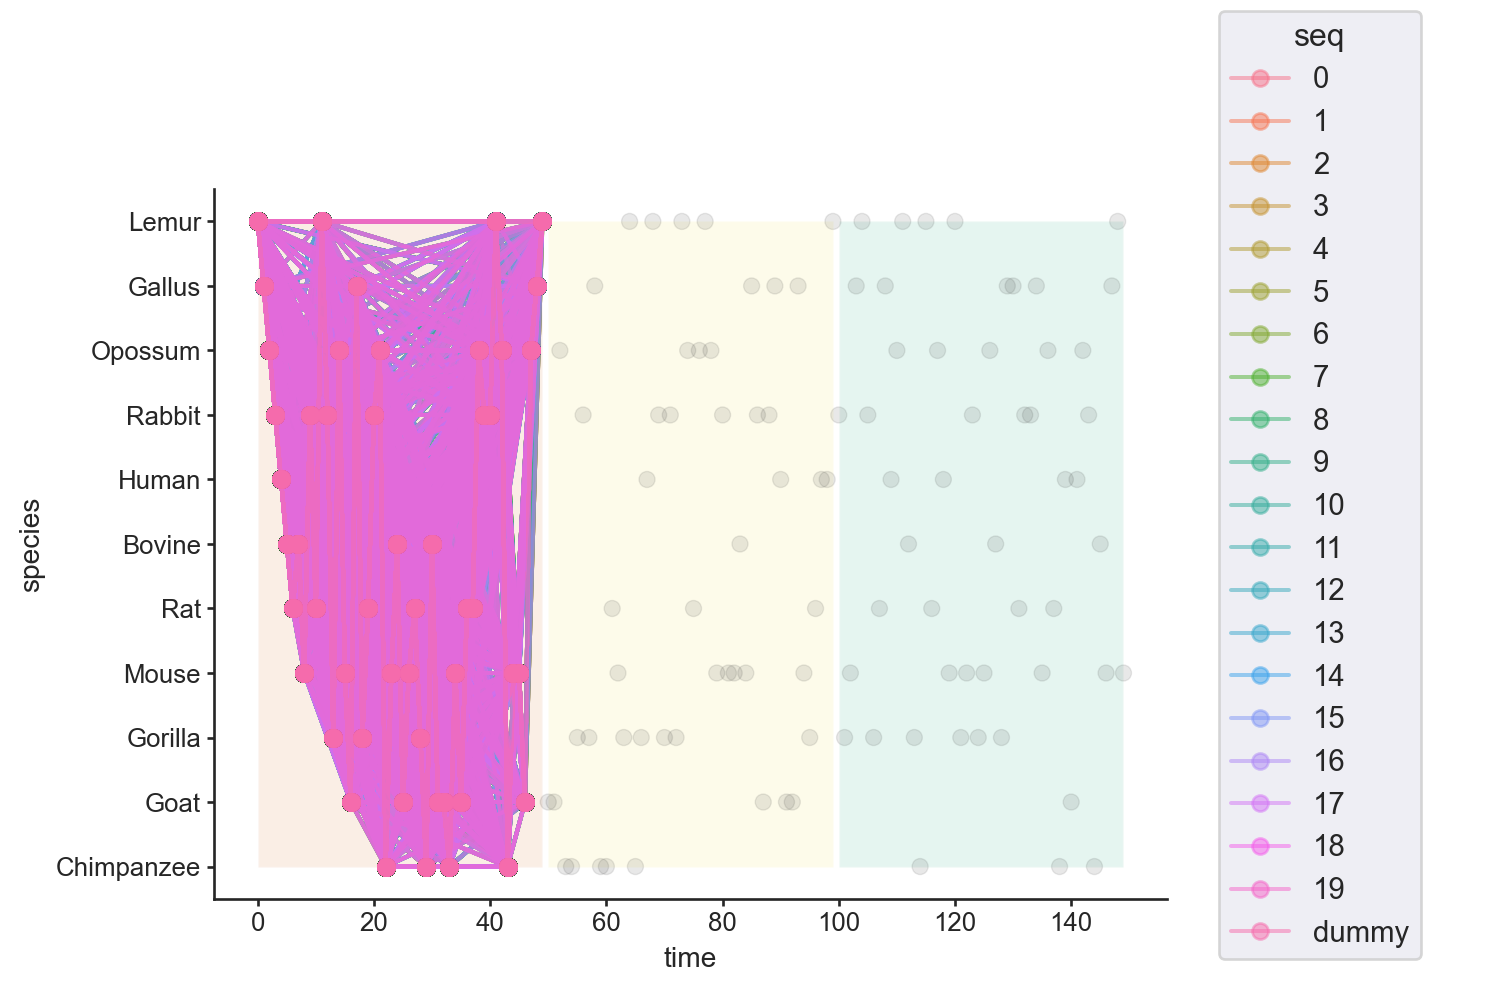

In [120]:
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()

i_prev = 0
colors = ["r", "y", "g"]
for c, i in zip(colors, episodes_size):
    rect = Rectangle((i_prev, 0), i - 1, len(species_index) - 1, linewidth=1, facecolor=c, alpha=0.1)
    ax.add_patch(rect)
    i_prev += i

(
    so.Plot(df_states, x="time", y="species")
    .add(so.Dot(color="k", alpha=0.1))
    .on(ax)
    .plot()
)

(
    so.Plot(df_sequences, x="time", y="species", color="seq")
    .add(so.Path(marker="o", alpha=0.5))
    .scale(color=so.Nominal())
    .on(ax)
    .plot()
)



In [134]:
def average_action_similarity(seqs):
    w1 = np.array(states[seqs[:, 1:]][:, :, 0], dtype=int)
    w2 = np.array(states[seqs[:, :-1]][:, :, 0], dtype=int)
    d = similarity_matrix[w1, w2]
    return d.mean(axis=1)

def average_time_difference(seqs):
    w1 = np.array(states[seqs[:, 1:]][:, :, 1], dtype=int)
    w2 = np.array(states[seqs[:, :-1]][:, :, 1], dtype=int)
    d = np.abs(w1 - w2)
    return d.mean(axis=1)

def average_episode_jumps(seqs):
    w1 = np.array(states[seqs[:, 1:]][:, :, 2], dtype=int)
    w2 = np.array(states[seqs[:, :-1]][:, :, 2], dtype=int)
    d = np.where(w1 == w2, 1, 0)
    return d.mean(axis=1)

def compute_metric(ms, ns, k=0):

    n_step = 50
    n_samp = 20
    df = pd.DataFrame()
    for m in ms:
        for n in ns:
            for metric in [average_action_similarity, average_time_difference, average_episode_jumps]:
                # Create the environment
                env = EpisodicGraph(states, similarity_matrix, k=k, m=m, n=n)

                # Create the generator
                generator = Generator(env)

                # Create the propagator
                propagator = Propagator(generator)

                # Create the simulator
                simulator = EpisodicSimulator(propagator, init_state)

                # Simulate
                simulator.sample_sequences(n_step=n_step, n_samp=n_samp)

                seqs = simulator.state_seqs

                metric_i = metric(seqs)
                df_i = pd.DataFrame({'metric': metric_i, 'm': m, 'n': n, 'metric_name': metric.__name__, "model": "new"})
           
                seqs_dummy = np.arange(init_state, n_step if init_state + n_step < n_states else n_states).reshape(1, -1)
                metric_i_dummy = metric(seqs_dummy)
                df_i_dummy = pd.DataFrame({'metric': metric_i_dummy, 'm': m, 'n': n, 'metric_name': metric.__name__, "model": "dummy"})
                df_i.append(df_i_dummy, ignore_index=True)
                df = df.append(df_i, ignore_index=True)
    return df


GENERATOR: generator constructed from environment transition matrix with jump_rate 15.00
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is symmetric.
GENERATOR: Q is a generator with shape (150, 150) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 3
EIGENSPECTRUM: algebraic multiplicity > 1.
GENERATOR: generator constructed from environment transition matrix with jump_rate 15.00
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is symmetric.
GENERATOR: Q is a generator with shape (150, 150) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 3
EIGENSPECTRUM: algebraic multiplicity > 1.
GENERATOR: generator constructed from environment transition matrix with jump_rate 15.00
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is symmetric.
GENERATOR: Q is a generator with shape (150, 150) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 3
EIGENSPECTRUM: algebraic multiplicity > 1.
GENERATOR: generator constructed from environment transition 

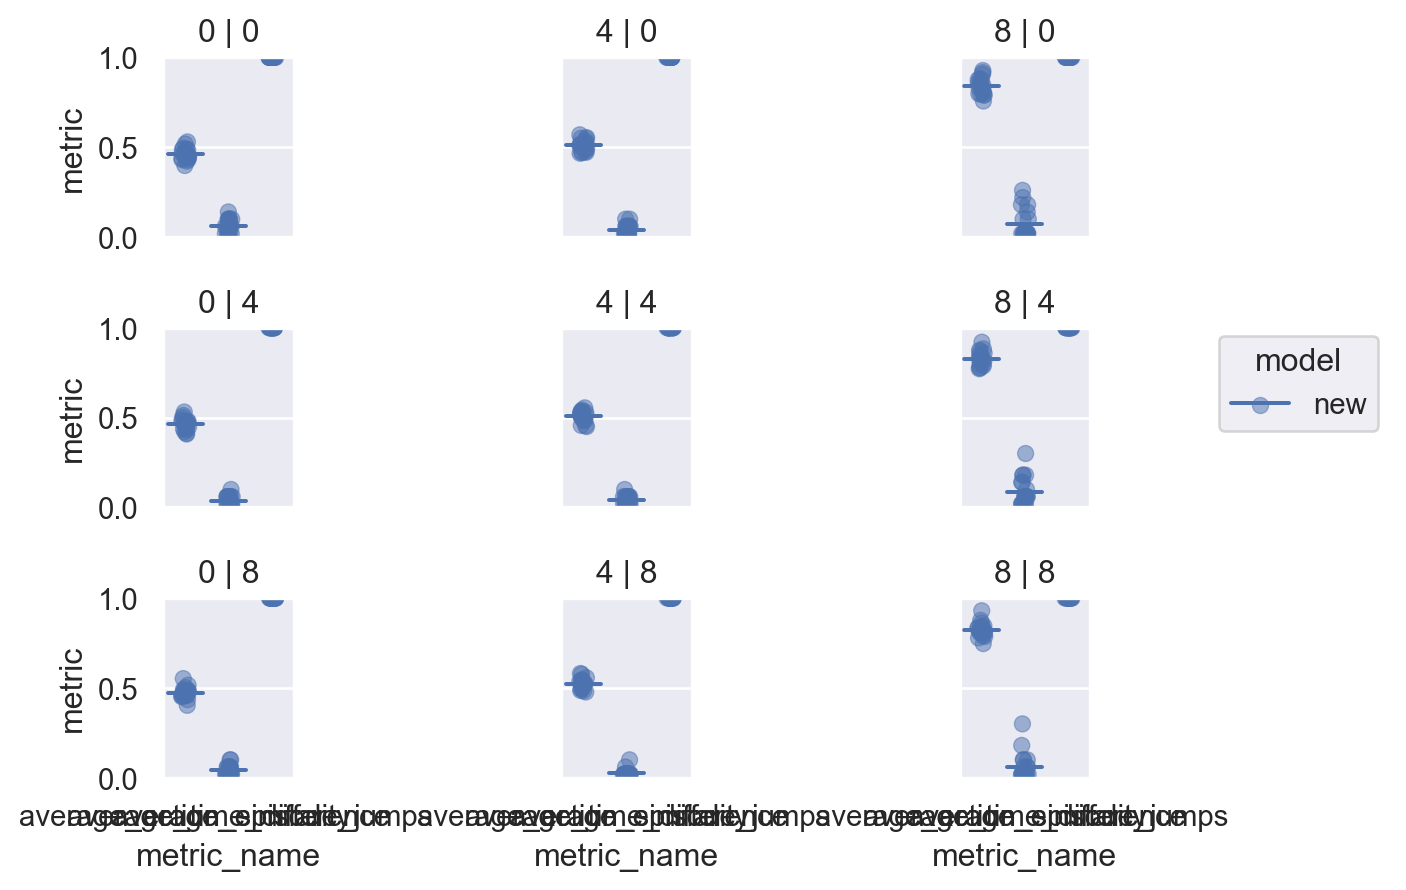

In [135]:
import seaborn.objects as so

ms = [0, 4, 8]
ns = [0, 4, 8]
k = 1

df_sim = compute_metric(ms, ns=ns)


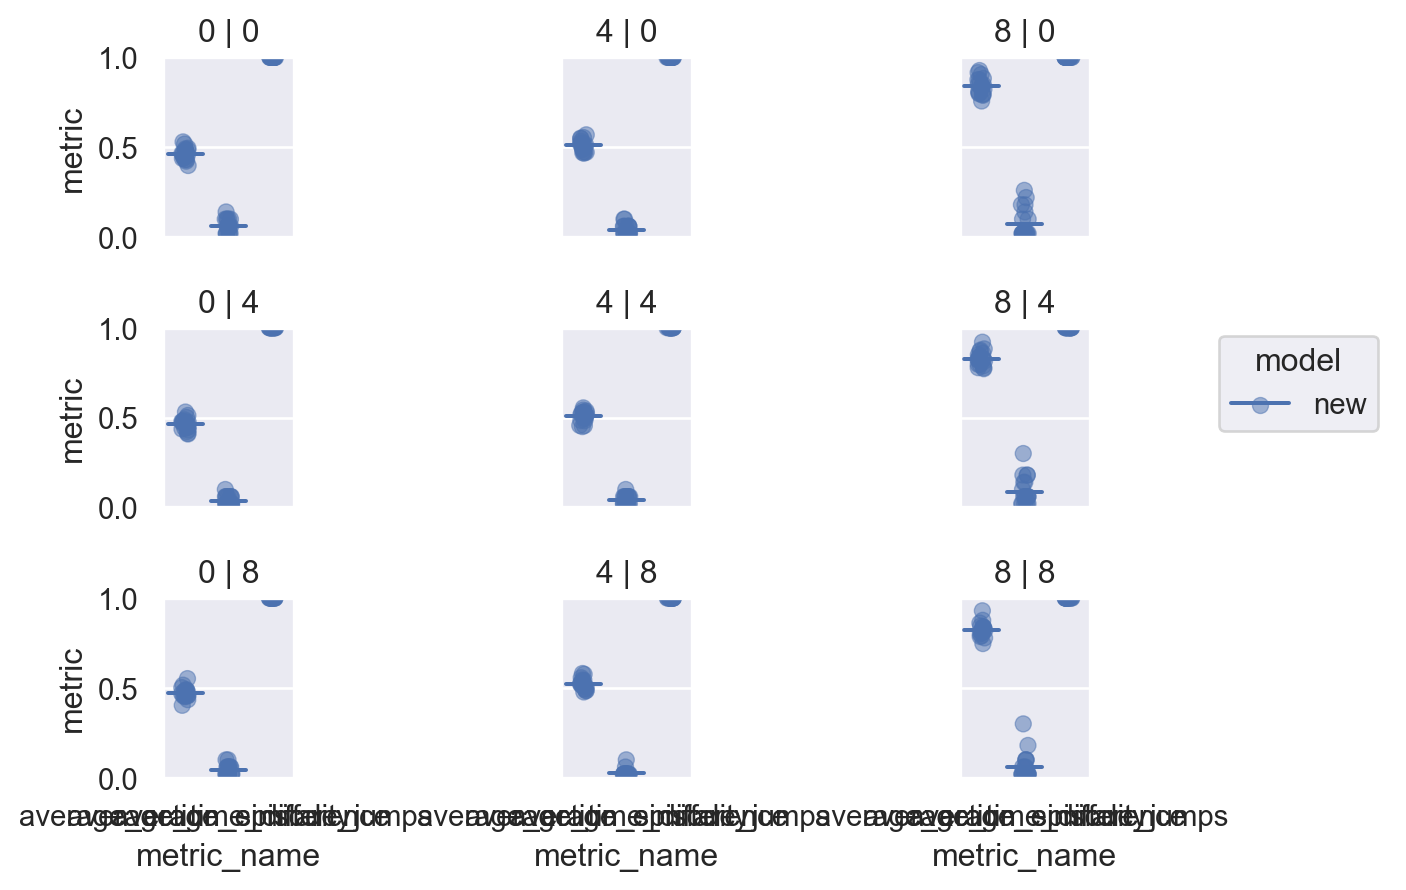

In [136]:
(
    so.Plot(df_sim, x="metric_name", color="model", y="metric")
    .facet("m", "n")
    .add(so.Dot(alpha=.5), so.Jitter(), so.Dodge())
    .add(so.Dash(), so.Agg(), so.Dodge())
    .limit(y=(0, 1))
)

In [139]:
df_sim["model"].unique()

array(['new'], dtype=object)